<a href="https://colab.research.google.com/github/rita68034/GNR_638_Assignment_2/blob/main/Assignment2_gnr638.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On the bag of words features calculated on UCM, make a three layer MLP. You can experiment on the number of nodes in the hidden layer, choice of activation etc.



In [1]:
!pip install tensorflow numpy scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Paths
zip_path = "/content/drive/My Drive/UCMerced_LandUse.zip"
extract_path = './dataset_extracted'

# Extract dataset if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("Extracting...")
        zip_ref.extractall(extract_path)
    print("Extraction successful.")

Extracting...
Extraction successful.


In [5]:
# Load images and labels
def load_images(image_dir, image_size=(200, 200)):
    images, labels = [], []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.tif', '.png', '.jpg')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path).convert("RGB").resize(image_size)
                    images.append(np.array(img))
                    labels.append(os.path.basename(root))
                except Exception as e:
                    print(f"Error loading {file}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_images(extract_path)
# Normalize image data
images = images / 255.0

In [6]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(np.unique(encoded_labels))

In [7]:
# Split data (same split for both parts)
X_train, X_test, y_train, y_test = train_test_split(
    images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

In [8]:
# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
### Part 1: Bag of Words Model ###
# Extract SIFT features
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors_list = []
    for img in images:
        gray_img = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        if descriptors is not None:
           # return descriptors
            descriptors_list.extend(descriptors)
    return np.array(descriptors_list)

def create_histograms(images, kmeans, n_clusters):
    sift = cv2.SIFT_create()
    histograms = []
    for img in images:
        gray_img = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        if descriptors is not None:
            clusters = kmeans.predict(descriptors)
            #return clusters
            hist, _ = np.histogram(clusters, bins=np.arange(n_clusters + 1))
            histograms.append(hist)
        else:
            histograms.append(np.zeros(n_clusters))
    return np.array(histograms)

In [10]:
# Create KMeans model
n_clusters = 500
descriptors = extract_sift_features(X_train)

In [11]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(descriptors)

KMeans(n_clusters=500, random_state=42)

In [12]:
# Generate BoW histograms
X_train_bow = create_histograms(X_train, kmeans, n_clusters)
X_test_bow = create_histograms(X_test, kmeans, n_clusters)

In [13]:
X_train_bow_cluster = np.sum(X_train_bow, axis=1, keepdims=True)[:,0]

In [14]:
# Normalize histograms
for i,image in enumerate(X_train_bow):
  image = image if X_train_bow_cluster[i] == 0 else image / X_train_bow_cluster[i]

In [15]:
X_test_bow_cluster = np.sum(X_test_bow, axis=1, keepdims=True)[:,0]

In [16]:
for i,image in enumerate(X_test_bow):
  image = image if X_test_bow_cluster[i] == 0 else image / X_test_bow_cluster[i]

In [17]:
# MLP Model for BoW
def build_mlp(input_shape, num_classes, hidden_layer_sizes=[256, 128, 64]):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(hidden_layer_sizes[0]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    for size in hidden_layer_sizes[1:]:
        model.add(Dense(size, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [18]:
mlp_bow_model = build_mlp(X_train_bow.shape[1], num_classes)
#mlp_bow_model.summary()
mlp_bow_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the MLP model
history_bow = mlp_bow_model.fit(X_train_bow, y_train_cat, validation_data=(X_test_bow, y_test_cat),
                                 epochs=20, batch_size=64, verbose=1)

# Evaluate BoW model
mlp_bow_test_acc = mlp_bow_model.evaluate(X_test_bow, y_test_cat, verbose=0)[1]
print(f"BoW MLP Test Accuracy: {mlp_bow_test_acc:.4f}")

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.1072 - loss: 2.9766 - val_accuracy: 0.2929 - val_loss: 2.4093
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3245 - loss: 2.2319 - val_accuracy: 0.3833 - val_loss: 2.0726
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4162 - loss: 1.8453 - val_accuracy: 0.5024 - val_loss: 1.6219
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4911 - loss: 1.5843 - val_accuracy: 0.5452 - val_loss: 1.4318
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5693 - loss: 1.3502 - val_accuracy: 0.5857 - val_loss: 1.3283
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5977 - loss: 1.2013 - val_accuracy: 0.6286 - val_loss: 1.1955
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6443 - loss: 1.1013 - val_accuracy: 0.6310 - val_loss: 1.1333
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6763 - loss: 1.0101 - val_accuracy: 0.6571 - val_los

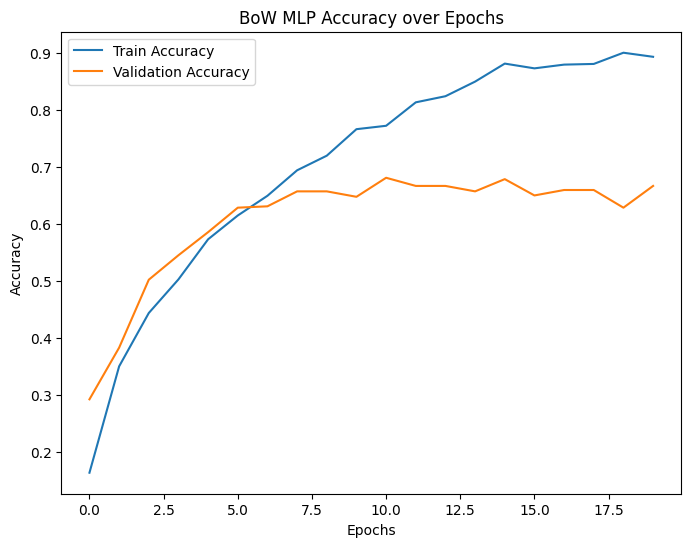

In [19]:
# Plot BoW performance
plt.figure(figsize=(8, 6))
plt.plot(history_bow.history['accuracy'], label='Train Accuracy')
plt.plot(history_bow.history['val_accuracy'], label='Validation Accuracy')
plt.title('BoW MLP Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Downscale each image of UCM to 72 x 72, linearized then, and again train a three layer MLP.

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.0825 - loss: 2.9825 - val_accuracy: 0.0500 - val_loss: 3.0318
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2298 - loss: 2.6745 - val_accuracy: 0.1119 - val_loss: 3.0053
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2555 - loss: 2.4142 - val_accuracy: 0.1571 - val_loss: 2.9390
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.3765 - loss: 2.0544 - val_accuracy: 0.1381 - val_loss: 2.8974
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4222 - loss: 1.9097 - val_accuracy: 0.1310 - val_loss: 2.8501
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5301 - loss: 1.5731 - val_accuracy: 0.1643 - val_loss: 2.8295
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.5691 - loss: 1.4559 - val_accuracy: 0.1690 - val_loss: 2.7299
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6088 - loss: 1.2487 - val_accuracy: 0.1548 - v

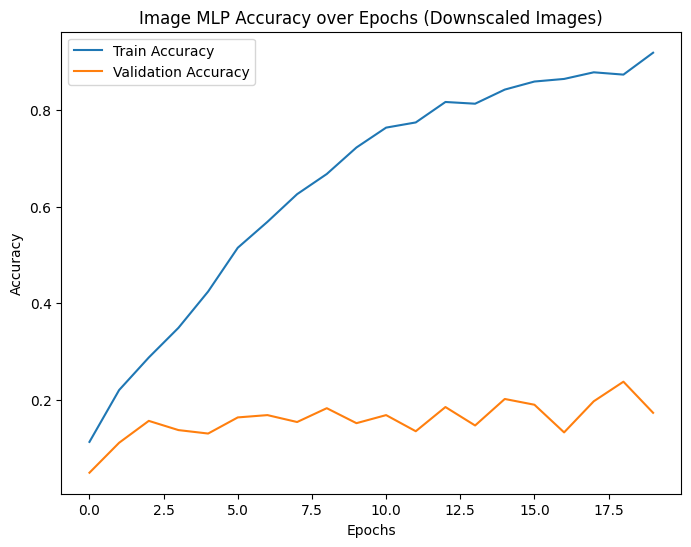

In [20]:
def resize_and_flatten(images, new_size=(72, 72)):
    resized_images = np.array([cv2.resize(img, new_size) for img in images])
    return resized_images.reshape(resized_images.shape[0], -1) / 255.0

# Resize and flatten the training and test data
X_train_flat = resize_and_flatten(X_train)
X_test_flat = resize_and_flatten(X_test)

mlp_image_model = build_mlp(X_train_flat.shape[1], num_classes)
mlp_image_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_image = mlp_image_model.fit(X_train_flat, y_train_cat, validation_data=(X_test_flat, y_test_cat),
                                     epochs=20, batch_size=32, verbose=1)

# Evaluate image MLP
mlp_image_test_acc = mlp_image_model.evaluate(X_test_flat, y_test_cat, verbose=0)[1]
print(f"Image MLP Test Accuracy: {mlp_image_test_acc:.4f}")

# Plot Image MLP performance
plt.figure(figsize=(8, 6))
plt.plot(history_image.history['accuracy'], label='Train Accuracy')
plt.plot(history_image.history['val_accuracy'], label='Validation Accuracy')
plt.title('Image MLP Accuracy over Epochs (Downscaled Images)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
print("Classification Report for BoW MLP:")
print(classification_report(y_test, np.argmax(mlp_bow_model.predict(X_test_bow), axis=1), target_names=label_encoder.classes_))

print("Classification Report for Image MLP:")
print(classification_report(y_test, np.argmax(mlp_image_model.predict(X_test_flat), axis=1), target_names=label_encoder.classes_))

Classification Report for BoW MLP:
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
                   precision    recall  f1-score   support

     agricultural       1.00      0.70      0.82        20
         airplane       0.88      0.75      0.81        20
  baseballdiamond       0.68      0.65      0.67        20
            beach       0.60      0.90      0.72        20
        buildings       0.27      0.15      0.19        20
        chaparral       0.91      1.00      0.95        20
 denseresidential       0.35      0.40      0.37        20
           forest       0.74      0.85      0.79        20
          freeway       0.65      0.85      0.74        20
       golfcourse       0.68      0.65      0.67        20
           harbor       1.00      1.00      1.00        20
     intersection       0.67      0.40      0.50        20
mediumresidential       0.46      0.65      0.54        20
   mobilehomepark       0.72      0.90      0.80        20
         overpass       0.59      0.80  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
